In [69]:
#Import Packages
import pandas as pd
import numpy as np
import os
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib
from textwrap import fill
from herbie import Herbie
import pickle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pysolar.solar as solar
from geographiclib.geodesic import Geodesic
import xarray as xr
import pytz

import sys
sys.path.append('..')
import funcs.ac_funcs as ac
import funcs.plotting as plotting
from config import run_config

import simplekml

pd.options.mode.chained_assignment = None

#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
figures_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Figures/'
pickle_data_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/'

In [71]:
#Loading the full datasets can take a while
dt1_str = '2022-05-23 00:00:00'
dt2_str =  '2022-12-01 00:00:00'
tz = 'UTC'

em27_data_folder_v1 = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v1/"
em27_data_folder_v2 = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct/"

oof_manage_v1 = ac.oof_manager(em27_data_folder_v1,tz)
em27_df_v1 = oof_manage_v1.load_oof_df_inrange(dt1_str,dt2_str,False)

oof_manage_v2 = ac.oof_manager(em27_data_folder_v2,tz)
em27_df_v2 = oof_manage_v2.load_oof_df_inrange(dt1_str,dt2_str,False)

## Flag Differences

We examine both V1 and V2 datasets for differences between flags. V2 has many more rows of flag=0 (good) data. All of the rows that are flag=0 in V2 and are NOT flag=0 in V1 are flag=99 in V1. 

In [43]:
flag0df_v1 = em27_df_v1.loc[em27_df_v1['flag']==0]
flag0df_v2 = em27_df_v2.loc[em27_df_v2['flag']==0]
diff_flag_idxs = flag0df_v2.index.difference(flag0df_v1.index)

diff_flags_df_v1 = em27_df_v1.loc[diff_flag_idxs]
diff_flags_df_v2 = em27_df_v2.loc[diff_flag_idxs]

print(f"V1 has {len(flag0df_v1)} rows of flag=0 data")
print(f"V2 has {len(flag0df_v2)} rows of flag=0 data")
print(f"V2 has {len(diff_flag_idxs)} more flag=0 data")

V1 has 229408 rows of flag=0 data
V2 has 240384 rows of flag=0 data
V2 has 10976 more flag=0 data


In [45]:
diff_flags_df_v1.groupby('flag').count()

,spectrum,year,day,hour,lat(deg),long(deg),zobs(km),zmin(km),solzen(deg),azim(deg),...,xlco2(ppm)_error,xwco2(ppm),xwco2(ppm)_error,xco2(ppm),xco2(ppm)_error,xo2,xo2_error,inst_zasl,inst_lat,inst_lon
flag,,,,,,,,,,,,,,,,,,,,,
99,10976,10976,10976,10976,10976,10976,10976,10976,10976,10976,...,10976,10976,10976,10976,10976,10976,10976,10976,10976,10976


In [82]:
10976/240384

0.04566027689030884

In [101]:
subtract_diff = flag0df_v1.drop(['spectrum'],axis = 1).subtract(flag0df_v2.drop(['spectrum'],axis=1))

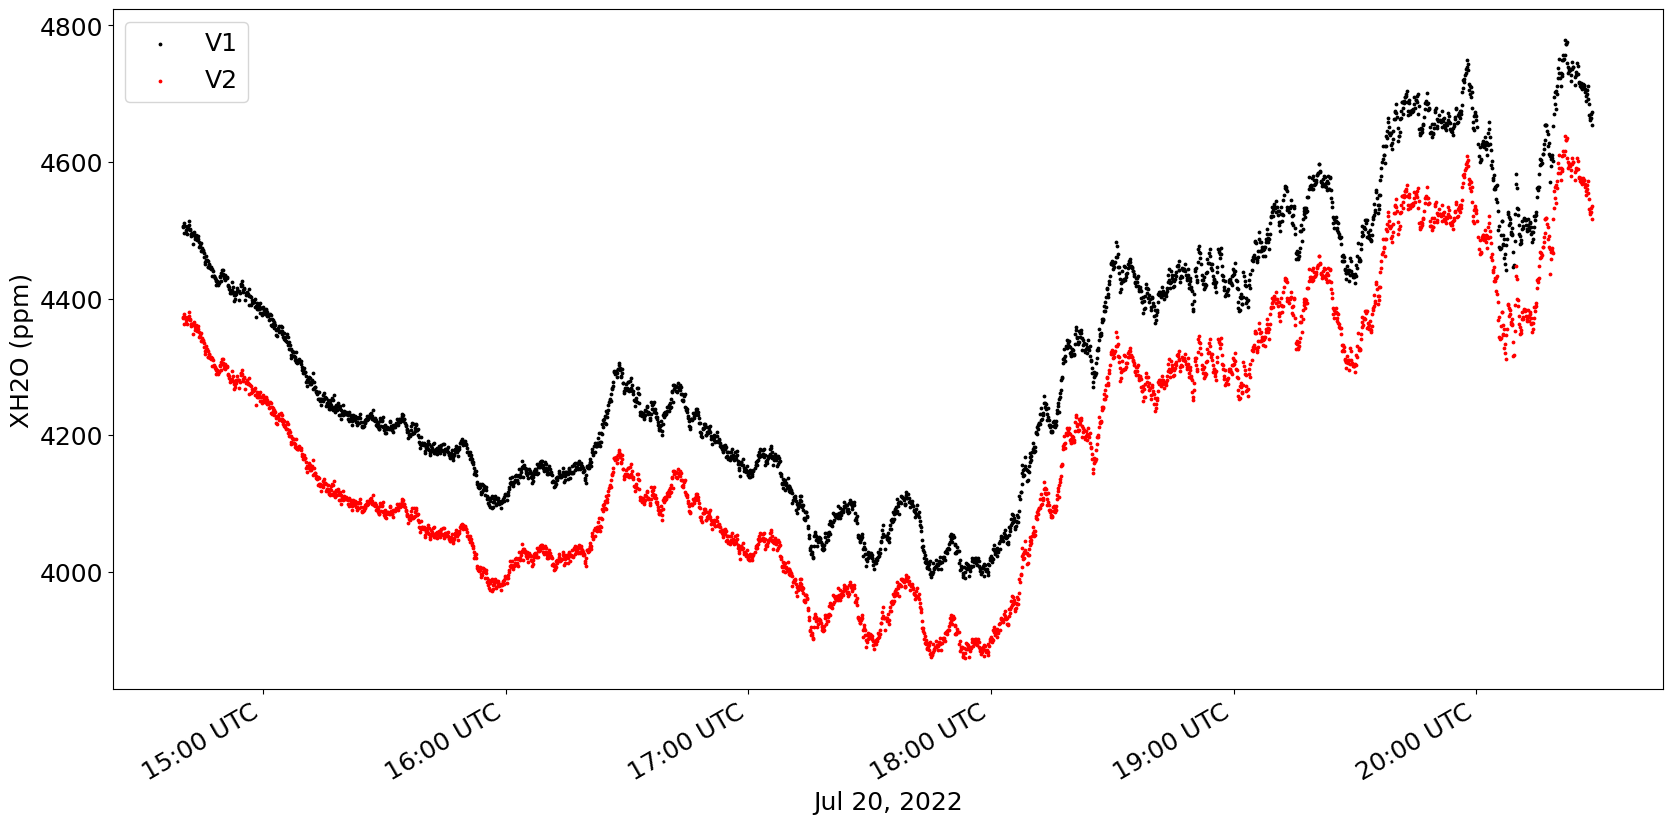

In [102]:
labsize = 18

plotdf_v1 = em27_df_v1.loc[(em27_df_v1.index>'2022-07-20')&
                       (em27_df_v1.index<'2022-07-23')]
plotdf_v2 = em27_df_v2.loc[(em27_df_v2.index>'2022-07-20')&
                       (em27_df_v2.index<'2022-07-23')]

fig,ax = plt.subplots(figsize = (20,10))
ax.scatter(plotdf_v1.index[10:],plotdf_v1['xh2o(ppm)'][10:],s=3,c='k',label='V1')
ax.scatter(plotdf_v2.index[10:],plotdf_v2['xh2o(ppm)'][10:],s=3,c='r',label='V2')
ax.set_ylabel('XH2O (ppm)',size = labsize)
ax.set_xlabel('Datetime (UTC)',size = labsize)
ax.tick_params(labelsize = labsize)
ax.legend(fontsize=labsize)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M %Z', tz = plotdf_v2.index.tz))
ax.set_xlabel(plotdf_v2.index[0].strftime('%b %d, %Y'),size = labsize)
plt.gcf().autofmt_xdate()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


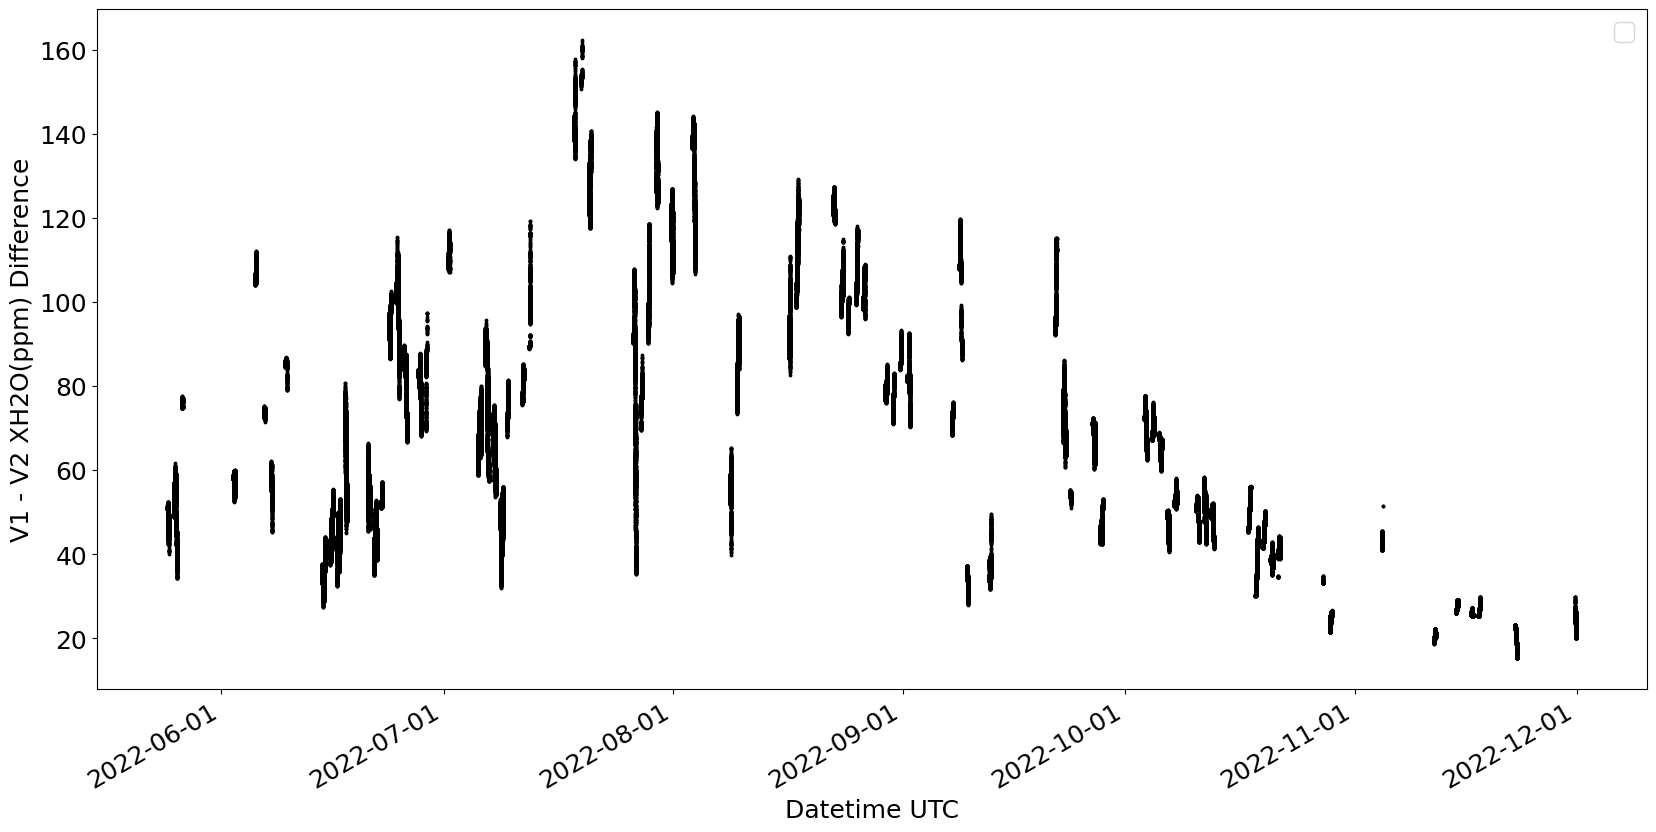

In [103]:
labsize = 18

fig,ax = plt.subplots(figsize = (20,10))
ax.scatter(subtract_diff.index,subtract_diff['xh2o(ppm)'],s=3,c='k')
ax.set_ylabel('V1 - V2 XH2O(ppm) Difference',size = labsize)
ax.set_xlabel('Datetime (UTC)',size = labsize)
ax.tick_params(labelsize = labsize)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz = plotdf_v2.index.tz))
ax.set_xlabel('Datetime UTC',size = labsize)
plt.gcf().autofmt_xdate()
plt.show()

In [109]:
summary_df = subtract_diff.describe().drop(['count','25%','50%','75%'])
summary_df.to_csv('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/v1_v2_subtraction_stats.csv')